In [19]:
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Optional, Tuple
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# sktime imports
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import ExpandingWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.impute import Imputer

# Algorithm imports
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.compose import TransformedTargetForecaster


class AdaptiveForecaster:
    """
    A user-friendly interface for time series forecasting using sktime.
    
    This class provides a simple interface for users to perform time series forecasting
    by abstracting away the complexities of the underlying algorithms and processes.
    
    Parameters
    ----------
    df : pandas.DataFrame or pandas.Series
        Input time series data in pandas DataFrame or Series format.
    target : str, optional
        Name of the target column to forecast. If None, the name of the Series is used.
    forecast_horizon : int, default=10
        Number of future time points to forecast.
    test_size : float or int, default=0.2
        Proportion of the data to use as test set or number of samples.
    algorithms : List[str] or str, default=None
        List of forecasting algorithms to use or 'auto' to try multiple algorithms.
        Options: 'naive', 'theta', 'arima', 'ets', 'exp_smoothing', 'ensemble'
    cross_validation : bool or Dict, default=False
        Whether to use cross-validation for model evaluation.
        If Dict, can specify cv parameters: {'method': 'expanding', 'initial': 10, 'step': 5}
    grid_search : bool or Dict, default=False
        Whether to use grid search for hyperparameter optimization.
        If Dict, can specify custom parameter grids for each algorithm.
    transformations : List[str] or str, default=None
        Data transformations to apply. Options: 'deseasonalize', 'detrend', 'boxcox', 'lag', 'impute'
    seasonal_period : int, default=None
        Period for seasonal decomposition if applicable.
    exog_variables : List[str], default=None
        List of exogenous variables to include in the forecasting model.
    impute_method : str, default='drift'
        Method to fill missing values when 'impute' transformation is used.
        Options: 'drift', 'linear', 'nearest', 'constant', 'mean', 'median', 'backfill'/'bfill', 
        'pad'/'ffill', 'random', 'forecaster'
    impute_value : int or float, default=None
        Value to use when impute_method='constant'.
    impute_forecaster : object, default=None
        Forecaster to use when impute_method='forecaster'.
    missing_values : str, int, float, regex, list, or None, default=None
        Value to consider as missing and impute, in addition to np.nan.
    """
    
    def __init__(
        self,
        df: Union[pd.DataFrame, pd.Series],
        target: str = None,
        forecast_horizon: int = 10,
        test_size: Union[float, int] = 0.2,
        algorithms: Union[List[str], str] = None,
        cross_validation: Union[bool, Dict] = False,
        grid_search: Union[bool, Dict] = False,
        transformations: Union[List[str], str] = None,
        seasonal_period: Optional[int] = None,
        exog_variables: Optional[List[str]] = None,
        impute_method: str = 'drift',
        impute_value: Optional[Union[int, float]] = None,
        impute_forecaster: Optional[object] = None,
        missing_values: Optional[Union[str, int, float, list]] = None
    ):
        # Handle Series input
        if isinstance(df, pd.Series):
            if target is None:
                target = df.name if df.name is not None else 'y'
            df = df.to_frame(name=target)
        
        # Initialize instance variables
        self.df = df.copy()
        self.target = target
        self.forecast_horizon = forecast_horizon
        self.test_size = test_size
        self.algorithms = algorithms if algorithms is not None else ['arima']
        self.cross_validation = cross_validation
        self.grid_search = grid_search
        self.transformations = transformations
        self.seasonal_period = seasonal_period
        self.exog_variables = exog_variables
        self.impute_method = impute_method
        self.impute_value = impute_value
        self.impute_forecaster = impute_forecaster
        self.missing_values = missing_values
        
        # Results storage
        self.y_train = None
        self.y_test = None
        self.X_train = None
        self.X_test = None
        self.fh = None
        self.forecasters = {}
        self.forecasts = {}
        self.metrics = {}
        self.best_model = None
        self.best_forecast = None
        
        # Validate inputs
        self._validate_inputs()
        
        # Prepare data
        self._prepare_data()
        
    def _validate_inputs(self):
        """Validate user inputs."""
        # Check if target exists in dataframe
        if self.target not in self.df.columns:
            raise ValueError(f"Target column '{self.target}' not found in dataframe.")
        
        # Handle algorithms parameter
        if isinstance(self.algorithms, str):
            if self.algorithms.lower() == 'auto':
                self.algorithms = ['naive', 'theta', 'arima', 'ets', 'exp_smoothing']
            else:
                self.algorithms = [self.algorithms]
                
        valid_algorithms = ['naive', 'theta', 'arima', 'ets', 'exp_smoothing', 'ensemble']
        for algo in self.algorithms:
            if algo.lower() not in valid_algorithms:
                raise ValueError(f"Algorithm '{algo}' not supported. Choose from {valid_algorithms}")
        
        # Handle transformations parameter
        if isinstance(self.transformations, str):
            self.transformations = [self.transformations]
            
        if self.transformations is not None:
            valid_transforms = ['deseasonalize', 'detrend', 'boxcox', 'lag', 'impute']
            for transform in self.transformations:
                if transform.lower() not in valid_transforms:
                    raise ValueError(f"Transformation '{transform}' not supported. Choose from {valid_transforms}")
                    
        # Check if seasonal_period is provided for seasonal transformations
        if self.transformations is not None and 'deseasonalize' in self.transformations and self.seasonal_period is None:
            raise ValueError("seasonal_period must be provided when using 'deseasonalize' transformation.")
            
        # Validate impute method if impute transformation is used
        if self.transformations is not None and 'impute' in self.transformations:
            valid_impute_methods = ['drift', 'linear', 'nearest', 'constant', 'mean', 'median', 
                                   'backfill', 'bfill', 'pad', 'ffill', 'random', 'forecaster']
            if self.impute_method not in valid_impute_methods:
                raise ValueError(f"Impute method '{self.impute_method}' not supported. Choose from {valid_impute_methods}")
                
            # Check if required parameters are provided for specific impute methods
            if self.impute_method == 'constant' and self.impute_value is None:
                raise ValueError("impute_value must be provided when impute_method='constant'")
                
            if self.impute_method == 'forecaster' and self.impute_forecaster is None:
                raise ValueError("impute_forecaster must be provided when impute_method='forecaster'")
            
        # Validate exogenous variables
        if self.exog_variables is not None:
            for var in self.exog_variables:
                if var not in self.df.columns:
                    raise ValueError(f"Exogenous variable '{var}' not found in dataframe.")
    
    def _prepare_data(self):
        """Prepare data for forecasting."""
        # Extract target and exogenous variables
        y = self.df[self.target].copy()
        
        # Ensure the index has a frequency if using seasonal transformations
        if (self.transformations is not None and 
            ('deseasonalize' in self.transformations or 'detrend' in self.transformations)):
            if y.index.freq is None:
                try:
                    # Try to infer and set frequency
                    inferred_freq = pd.infer_freq(y.index)
                    if inferred_freq is not None:
                        y = y.copy()
                        y.index = pd.DatetimeIndex(y.index, freq=inferred_freq)
                    else:
                        print("Warning: Could not infer frequency from time series index. "
                              "This may cause issues with seasonal decomposition.")
                except Exception as e:
                    print(f"Warning: Error setting frequency: {str(e)}")
        
        X = None
        if self.exog_variables is not None:
            X = self.df[self.exog_variables].copy()
        
        # Create train-test split
        if X is None:
            self.y_train, self.y_test = temporal_train_test_split(y, test_size=self.test_size)
            self.X_train, self.X_test = None, None
        else:
            self.y_train, self.y_test, self.X_train, self.X_test = temporal_train_test_split(
                y, X, test_size=self.test_size
            )
            
        # Create forecasting horizon
        self.fh = ForecastingHorizon(
            np.arange(1, self.forecast_horizon + 1), is_relative=True
        )
        
    def _get_cv_splitter(self, cv_params):
        """Create cross-validation splitter."""
        method = cv_params.get('method', 'expanding')
        initial = cv_params.get('initial', 10)
        step = cv_params.get('step', 5)
        
        if method == 'expanding':
            return ExpandingWindowSplitter(
                initial_window=initial,
                step_length=step,
                fh=self.fh
            )
        elif method == 'sliding':
            return SlidingWindowSplitter(
                initial_window=initial,
                window_length=initial,
                step_length=step,
                fh=self.fh
            )
        else:
            raise ValueError(f"CV method '{method}' not supported. Choose from 'expanding' or 'sliding'.")
    
    def _get_algorithm(self, name, with_transformations=True):
        """Get a forecasting algorithm by name."""
        algorithm = None
        
        if name.lower() == 'naive':
            algorithm = NaiveForecaster(strategy="mean")
        elif name.lower() == 'theta':
            algorithm = ThetaForecaster()
        elif name.lower() == 'arima':
            algorithm = AutoARIMA(
                start_p=1, start_q=1, max_p=3, max_q=3, 
                seasonal=self.seasonal_period is not None,
                sp=self.seasonal_period,
                d=1, max_d=2,
                suppress_warnings=True
            )
        elif name.lower() == 'ets':
            algorithm = AutoETS(
                auto=True, 
                seasonal=self.seasonal_period is not None,
                sp=self.seasonal_period
            )
        elif name.lower() == 'exp_smoothing':
            algorithm = ExponentialSmoothing(
                seasonal=self.seasonal_period is not None,
                sp=self.seasonal_period
            )
        elif name.lower() == 'ensemble':
            # Only create ensemble if we have other algorithms
            if len(self.forecasters) < 2:
                raise ValueError("Ensemble requires at least 2 other algorithms to be trained first.")
            
            forecaster_list = list(self.forecasters.values())
            algorithm = EnsembleForecaster(forecasters=forecaster_list)
            
        # Apply transformations if specified
        if with_transformations and self.transformations is not None and algorithm is not None:
            algorithm = self._apply_transformations(algorithm)
            
        return algorithm
    
    def _apply_transformations(self, forecaster):
        """Apply specified transformations to a forecaster."""
        transformers = []
        
        if self.transformations is None:
            return forecaster
        
        for transform in self.transformations:
            if transform.lower() == 'deseasonalize':
                transformers.append(
                    ("deseasonalize", Deseasonalizer(sp=self.seasonal_period))
                )
            elif transform.lower() == 'detrend':
                transformers.append(
                    ("detrend", Detrender())
                )
            elif transform.lower() == 'boxcox':
                transformers.append(
                    ("boxcox", BoxCoxTransformer())
                )
            elif transform.lower() == 'lag':
                lag_values = [1, 2, 3]  # Example lag values
                transformers.append(
                    ("lag", Lag(lags=lag_values))
                )
            elif transform.lower() == 'impute':
                # Configure imputer based on parameters
                if self.impute_method == 'constant':
                    imputer = Imputer(
                        method=self.impute_method,
                        value=self.impute_value,
                        missing_values=self.missing_values
                    )
                elif self.impute_method == 'forecaster':
                    imputer = Imputer(
                        method=self.impute_method,
                        forecaster=self.impute_forecaster,
                        missing_values=self.missing_values
                    )
                elif self.impute_method == 'random':
                    imputer = Imputer(
                        method=self.impute_method,
                        random_state=42,  # Using a fixed seed for reproducibility
                        missing_values=self.missing_values
                    )
                else:
                    imputer = Imputer(
                        method=self.impute_method,
                        missing_values=self.missing_values
                    )
                
                transformers.append(
                    ("impute", imputer)
                )
                
        if not transformers:
            return forecaster
            
        transformed_forecaster = TransformedTargetForecaster(
            steps=[*transformers, ("forecaster", forecaster)]
        )
        
        return transformed_forecaster
    
    def _get_param_grid(self, algorithm_name):
        """Get default parameter grid for an algorithm."""
        if isinstance(self.grid_search, dict) and algorithm_name in self.grid_search:
            return self.grid_search[algorithm_name]
            
        # Default parameter grids
        if algorithm_name == 'naive':
            return {"strategy": ["mean", "last", "drift"]}
        elif algorithm_name == 'theta':
            return {"theta": [0, 0.5, 1, 1.5, 2]}
        elif algorithm_name == 'arima':
            return {"d": [0, 1], "max_p": [2, 3], "max_q": [2, 3]}
        elif algorithm_name == 'ets':
            return {"error": ["add", "mul"], "trend": ["add", "mul", None]}
        elif algorithm_name == 'exp_smoothing':
            return {
                "trend": ["add", "mul", None],
                "seasonal": ["add", "mul", None],
                "damped_trend": [True, False]
            }
        else:
            return {}
            
    def fit(self):
        """Fit all specified forecasting models."""
        for algorithm_name in self.algorithms:
            print(f"Fitting {algorithm_name.upper()} model...")
            
            # Get base forecaster
            forecaster = self._get_algorithm(algorithm_name)
            
            if forecaster is None:
                continue
                
            # Apply grid search if specified
            if self.grid_search:
                param_grid = self._get_param_grid(algorithm_name)
                
                if self.cross_validation:
                    # Configure CV splitter
                    cv_params = self.cross_validation if isinstance(self.cross_validation, dict) else {}
                    cv = self._get_cv_splitter(cv_params)
                else:
                    cv = None
                    
                if param_grid and len(param_grid) > 0:
                    print(f"  Performing grid search for {algorithm_name}...")
                    forecaster = ForecastingGridSearchCV(
                        forecaster,
                        param_grid=param_grid,
                        cv=cv,
                        scoring="neg_mean_absolute_percentage_error"
                    )
            
            # Fit the forecaster
            if self.X_train is None:
                forecaster.fit(self.y_train)
            else:
                forecaster.fit(self.y_train, X=self.X_train)
                
            # Store the fitted forecaster
            self.forecasters[algorithm_name] = forecaster
            
        # Add ensemble if specified
        if 'ensemble' in self.algorithms and len(self.forecasters) > 1:
            print("Fitting ENSEMBLE model...")
            ensemble_forecaster = self._get_algorithm('ensemble')
            
            if self.X_train is None:
                ensemble_forecaster.fit(self.y_train)
            else:
                ensemble_forecaster.fit(self.y_train, X=self.X_train)
                
            self.forecasters['ensemble'] = ensemble_forecaster
            
        print("All models fitted successfully!")
        return self
    
    def predict(self):
        """Generate forecasts for all fitted models."""
        for name, forecaster in self.forecasters.items():
            print(f"Generating forecast for {name.upper()}...")
            
            # Generate forecast
            if self.X_test is None:
                forecast = forecaster.predict(fh=self.fh)
            else:
                forecast = forecaster.predict(fh=self.fh, X=self.X_test)
                
            self.forecasts[name] = forecast
            
            # Calculate metrics if test data is available
            if len(self.y_test) >= self.forecast_horizon:
                y_test_pred = self.y_test.iloc[:self.forecast_horizon]
                
                mae = mean_absolute_error(y_test_pred, forecast[:len(y_test_pred)])
                mse = mean_squared_error(y_test_pred, forecast[:len(y_test_pred)])
                rmse = np.sqrt(mse)
                mape = mean_absolute_percentage_error(y_test_pred, forecast[:len(y_test_pred)])
                
                self.metrics[name] = {
                    'mae': mae,
                    'mse': mse,
                    'rmse': rmse,
                    'mape': mape
                }
                
        # Determine best model based on RMSE
        if self.metrics:
            best_model_name = min(self.metrics, key=lambda x: self.metrics[x]['rmse'])
            self.best_model = best_model_name
            self.best_forecast = self.forecasts[best_model_name]
            
        print("All forecasts generated successfully!")
        return self
    
    def get_summary(self):
        """Get a summary of forecasting results."""
        if not self.metrics:
            return "No metrics available. Run predict() first."
            
        summary_df = pd.DataFrame(index=self.metrics.keys())
        
        # Add metrics columns
        for metric in ['mae', 'mse', 'rmse', 'mape']:
            summary_df[metric.upper()] = [self.metrics[model][metric] for model in summary_df.index]
            
        # Highlight best model
        if self.best_model:
            summary_df['Best'] = [model == self.best_model for model in summary_df.index]
            
        return summary_df.sort_values('RMSE')
    
    def plot_forecasts(self, models=None, figsize=(12, 8)):
        """Plot forecasts against actual values."""
        if not self.forecasts:
            raise ValueError("No forecasts available. Run predict() first.")
            
        # Determine which models to plot
        if models is None:
            models = list(self.forecasts.keys())
        elif isinstance(models, str):
            if models.lower() == 'best' and self.best_model:
                models = [self.best_model]
            else:
                models = [models]
                
        # Create plot
        plt.figure(figsize=figsize)
        
        # Convert Period index to datetime if needed
        y_train_index = self.y_train.index
        if hasattr(y_train_index, 'to_timestamp'):
            y_train_index = y_train_index.to_timestamp()
        
        # Plot historical data
        plt.plot(y_train_index, self.y_train.values, label='Historical Data', color='black')
        
        # Plot test data if available
        if len(self.y_test) > 0:
            y_test_index = self.y_test.index
            if hasattr(y_test_index, 'to_timestamp'):
                y_test_index = y_test_index.to_timestamp()
            
            plt.plot(y_test_index[:self.forecast_horizon], 
                    self.y_test.values[:self.forecast_horizon], 
                    label='Actual Values', 
                    color='green', 
                    linestyle='--')
        
        # Plot forecasts
        colors = ['blue', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan']
        for i, model in enumerate(models):
            if model in self.forecasts:
                forecast = self.forecasts[model]
                color = colors[i % len(colors)]
                
                # Ensure forecast index is compatible with y_test index
                forecast_index = forecast.index
                if hasattr(forecast_index, 'to_timestamp'):
                    forecast_index = forecast_index.to_timestamp()
                
                plt.plot(forecast_index, forecast.values, 
                         label=f'{model.capitalize()} Forecast', 
                         color=color, 
                         linestyle='-.')
        
        # Add legend and labels
        plt.legend()
        plt.title(f'Forecast for {self.target}')
        plt.xlabel('Time')
        plt.ylabel(self.target)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        return plt
    
    def plot_metrics(self, figsize=(10, 6)):
        """Plot performance metrics for all models."""
        if not self.metrics:
            raise ValueError("No metrics available. Run predict() first.")
            
        # Create a DataFrame with metrics
        metrics_df = pd.DataFrame(self.metrics).T
        
        # Plot metrics
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        axes = axes.flatten()
        
        metrics = ['mae', 'mse', 'rmse', 'mape']
        titles = ['Mean Absolute Error', 'Mean Squared Error', 
                 'Root Mean Squared Error', 'Mean Absolute Percentage Error']
        
        for i, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[i]
            metrics_df[metric].plot(kind='bar', ax=ax, color='skyblue')
            ax.set_title(title)
            ax.set_ylabel(metric.upper())
            ax.grid(True, alpha=0.3, axis='y')
            
            # Highlight best model
            if self.best_model:
                best_idx = metrics_df.index.get_loc(self.best_model)
                ax.patches[best_idx].set_facecolor('green')
        
        plt.tight_layout()
        return plt
    
    def get_future_forecast(self, steps=None, model='best'):
        """Generate forecast for future periods beyond the test set."""
        if steps is None:
            steps = self.forecast_horizon
            
        # Determine which model to use
        if model == 'best' and self.best_model:
            forecaster = self.forecasters[self.best_model]
        elif model in self.forecasters:
            forecaster = self.forecasters[model]
        else:
            raise ValueError(f"Model '{model}' not found. Available models: {list(self.forecasters.keys())}")
            
        # Create future horizon
        future_fh = ForecastingHorizon(np.arange(1, steps + 1), is_relative=True)
        
        # Generate future forecast using all available data
        full_data = pd.concat([self.y_train, self.y_test])
        
        if self.X_train is not None and self.X_test is not None:
            full_X = pd.concat([self.X_train, self.X_test])
            # Refit the forecaster with all data
            forecaster.fit(full_data, X=full_X)
            # Generate future forecast
            future_forecast = forecaster.predict(fh=future_fh, X=full_X)
        else:
            # Refit the forecaster with all data
            forecaster.fit(full_data)
            # Generate future forecast
            future_forecast = forecaster.predict(fh=future_fh)
            
        return future_forecast
    
    def export_results(self, filename=None):
        """Export forecasting results to CSV."""
        if not self.forecasts:
            raise ValueError("No forecasts available. Run predict() first.")
            
        # Create a DataFrame with all forecasts
        result_df = pd.DataFrame()
        
        # Add actual values if available
        if len(self.y_test) > 0:
            result_df['Actual'] = self.y_test.iloc[:self.forecast_horizon]
            
        # Add forecasts
        for name, forecast in self.forecasts.items():
            result_df[f'{name.capitalize()} Forecast'] = forecast
            
        # Add errors if actual values are available
        if 'Actual' in result_df.columns:
            for name in self.forecasts.keys():
                forecast_col = f'{name.capitalize()} Forecast'
                result_df[f'{name.capitalize()} Error'] = result_df['Actual'] - result_df[forecast_col]
                
        # Export to CSV if filename provided
        if filename:
            if not filename.endswith('.csv'):
                filename += '.csv'
            result_df.to_csv(filename)
            print(f"Results exported to {filename}")
            
        return result_df

    def check_missing_values(self):
        """Check for missing values in the dataset and return a summary."""
        missing_summary = {}
        
        # Check target variable
        target_missing = self.df[self.target].isna().sum()
        missing_summary[self.target] = {
            'count': target_missing,
            'percentage': (target_missing / len(self.df)) * 100
        }
        
        # Check exogenous variables if any
        if self.exog_variables is not None:
            for var in self.exog_variables:
                var_missing = self.df[var].isna().sum()
                missing_summary[var] = {
                    'count': var_missing,
                    'percentage': (var_missing / len(self.df)) * 100
                }
        
        # Create a DataFrame for better visualization
        summary_df = pd.DataFrame({
            'Missing Count': {k: v['count'] for k, v in missing_summary.items()},
            'Missing Percentage': {k: v['percentage'] for k, v in missing_summary.items()}
        })
        
        return summary_df



Missing Values Summary:
                              Missing Count  Missing Percentage
Number of airline passengers              0                 0.0
Fitting NAIVE model...
Fitting ARIMA model...


/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/yaeg/Documents

Fitting ETS model...
All models fitted successfully!
Generating forecast for NAIVE...
Generating forecast for ARIMA...
Generating forecast for ETS...
All forecasts generated successfully!
              MAE           MSE        RMSE      MAPE   Best
ets     51.412976   4530.716512   67.310597  0.107592   True
arima   75.993478   8986.766778   94.798559  0.155481  False
naive  202.131588  44308.877450  210.496740  0.437986  False


/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<module 'matplotlib.pyplot' from '/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

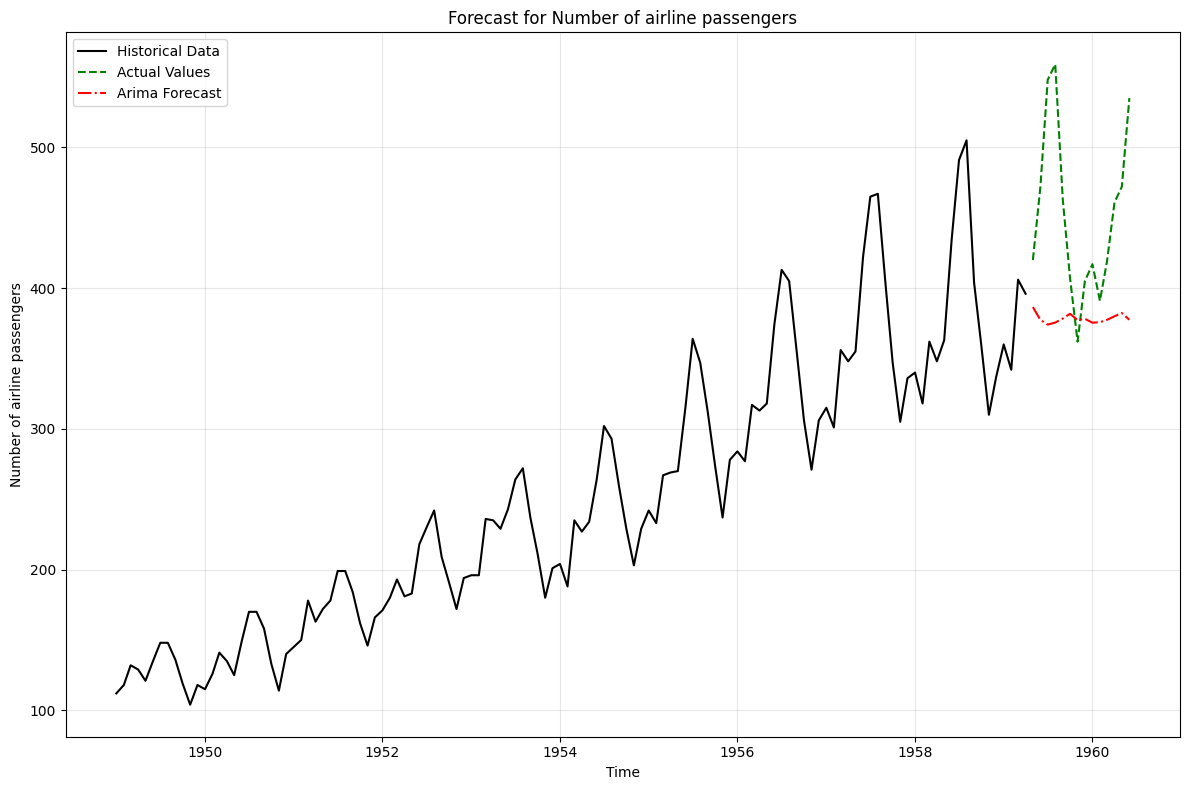

In [22]:
import numpy as np
from sktime.datasets import load_airline
"""    
    # Create date range
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
    
    # Create time series with trend, seasonality and noise
trend = np.linspace(0, 10, 100)
seasonality = 5 * np.sin(np.linspace(0, 10 * np.pi, 100))
noise = np.random.normal(0, 1, 100)
    
    # Combine components
y = trend + seasonality + noise
    
    # Create DataFrame with some missing values
df = pd.DataFrame({
        'date': dates,
        'sales': y,
        'promo': np.random.choice([0, 1], size=100, p=[0.7, 0.3])  # Example exogenous variable
    })
    
    # Introduce some missing values
df.loc[10:15, 'sales'] = np.nan
df.loc[50:52, 'promo'] = np.nan
"""
df = load_airline()
#df = data.to_dataframe()
#df.set_index('date', inplace=True)
    
    # Create and use the forecaster with imputation
forecaster = AdaptiveForecaster(
        df=df,
        #target='sales',
        forecast_horizon=14,
        test_size=20,
        algorithms=['naive', 'arima', 'ets'],
        transformations=['impute', 'deseasonalize'],
        impute_method='mean',
        seasonal_period=7,
        #exog_variables=['promo']
    )
    
    # Check missing values
missing_summary = forecaster.check_missing_values()
print("Missing Values Summary:")
print(missing_summary)
    
    # Fit models
forecaster.fit()
    
    # Generate forecasts
forecaster.predict()
    
    # Get summary of results
summary = forecaster.get_summary()
print(summary)
    
    # Plot forecasts
forecaster.plot_forecasts(models=['best', 'arima'])

In [14]:
data

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adaptiveforecast.interface import AdaptiveForecaster
from sktime.datasets import load_airline

# Load the airline passengers dataset
df = load_airline()
# Advanced usage with grid search and MultiplexForecaster
print("\n\n=== ADVANCED USAGE WITH GRID SEARCH AND MULTIPLEXFORECASTER ===")
# Define custom parameter grids for each algorithm
param_grid = {
    'naive': {'strategy': ['last', 'mean', 'drift']},
    'arima': {'d': [0, 1], 'max_p': [2, 3], 'max_q': [2, 3]},
    'ets': {'error': ['add', 'mul'], 'trend': ['add', 'mul', None], 'damped_trend': [True, False]}
}

# Define cross-validation parameters
cv_params = {
    'method': 'expanding',
    'initial': 36,
    'step': 12
}

advanced_forecaster = AdaptiveForecaster(
    df=df,
    forecast_horizon=12,
    test_size=24,
    algorithms=['naive', 'arima', 'ets'],
    transformations=['deseasonalize'],
    seasonal_period=12,
    grid_search=param_grid,
    cross_validation=cv_params,
    use_multiplex=True,
    scoring="mape",
    selected_forecasters=['ets']
)

# Fit models with grid search
advanced_forecaster.fit()

# Print cross-validation results
advanced_forecaster.print_cv_results(n_best=10)

# Generate forecasts
advanced_forecaster.predict()

# Get summary of results
advanced_summary = advanced_forecaster.get_summary()
print("\nAdvanced Forecast Summary:")
print(advanced_summary)

# Plot forecasts
plt.figure(figsize=(12, 6))
advanced_forecaster.plot_forecasts(models=['multiplex', 'best'])
plt.title("Advanced Forecast with Grid Search")
plt.tight_layout()
plt.savefig("advanced_forecast.png")
plt.close()


/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/skbase/base/_clone_plugins.py:121: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns with the automatic model selection.
  new_object = klass(**new_object_params)
/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/skbase/base/_clone_plugins.py:121: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns 

Best algorithm selected: ETS
Best parameters: {'ets__damped_trend': True, 'ets__error': 'add', 'ets__trend': 'add', 'selected_forecaster': 'ets'}
Best score: 0.0891


/home/yaeg/Documents/projects/packages/AdaptiveForecast/adaptiveforecast/interface.py:339: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns with the automatic model selection.
  algorithm = AutoETS(
/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/skbase/base/_clone_plugins.py:121: UserWarning: The user-specified parameters provided alongside auto=True in AutoETS may not be respected. The AutoETS function automatically selects the best model based on the information criterion, ignoring the error, trend, seasonal, and damped_trend parameters when auto=True is set. Please ensure that your intended behavior aligns with the automatic model selection.
  new_object = kl

MultiplexForecaster fitted successfully!

CROSS-VALIDATION RESULTS (TOP 10)
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Generating forecast with MultiplexForecaster...
Best algorithm selected by MultiplexForecaster: ETS
Generating forecast for ETS...
All forecasts generated successfully!

FORECAST RESULTS FOR NUMBER OF AIRLINE PASSENGERS

BEST MODEL: MULTIPLEX

MULTIPLEX FORECAST:
--------------------------------------------------
         Multiplex Forecast  Actual  Error  Percent Error
1959-01              354.95   360.0   5.05           1.40
1959-02              339.22   342.0   2.78           0.81
1959-03              390.06   406.0  15.94           3.93
1959-04              382.51   396.0  13.49           3.41
1959-05              399.65   420.0  20.35           4.85
1959-06              470.40   472.0   1.60           0.34
1959-07              520.32   548.0  27.68           5.05
1959-08              524.22   559.0  34.78           6.22
1959-09              

<Figure size 1200x600 with 0 Axes>

In [9]:
advanced_forecaster.

'multiplex'

In [41]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.transformations.series.impute import Imputer
y = load_shampoo_sales()
pipe = TransformedTargetForecaster(steps=[
    ("imputer", Imputer()),
    ("forecaster", ExponentialSmoothing(damped_trend=True, trend='add'))])
cv = ExpandingWindowSplitter(
    initial_window=24,
    step_length=12,
    fh=[1,2,3])
gscv = ForecastingGridSearchCV(
    forecaster=pipe,
    param_grid=[{
        "forecaster": [ExponentialSmoothing(sp=12)],
        "imputer__method": ["mean", "drift"],
        
    }
    ],
    cv=cv,
)  
gscv.fit(y)  
y_pred = gscv.predict(fh=[1,2,3])  

In [24]:
test_pred = gscv.get_fitted_params()['best_forecaster'].fit(y)

/home/yaeg/Documents/projects/packages/AdaptiveForecast/.venv/lib/python3.9/site-packages/sktime/forecasting/naive.py:184: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn(


In [25]:
test_pred.predict(fh=[1,2,3])

1994-01    657.782857
1994-02    668.665714
1994-03    679.548571
Freq: M, Name: Number of shampoo sales, dtype: float64

In [18]:
y_pred

1994-01    657.782857
1994-02    668.665714
1994-03    679.548571
Freq: M, Name: Number of shampoo sales, dtype: float64

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")
warnings.filterwarnings("ignore", message="The user-specified parameters provided alongside auto=True in AutoETS may not be respected")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adaptiveforecast.core import AdaptiveForecaster
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.detrend import Detrender,Deseasonalizer
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.lag import Lag
from sktime.transformations.series.impute import Imputer    
from sktime.forecasting.compose import TransformedTargetForecaster
# Load the airline passengers dataset
df = load_airline()
# Advanced usage with grid search and MultiplexForecaster
print("\n\n=== ADVANCED USAGE WITH GRID SEARCH AND MULTIPLEXFORECASTER ===")

seasonal_period = 12
algorithms=['naive']
transformations={
    'naive':None,
    'arima':['deseasonalize','detrend'],
    'exp_smoothing':['impute']
}
# Define custom parameter grids for each algorithm
parameters = {
    'naive': {'strategy': ['last', 'mean', 'drift']},
    'arima': {'d': [0, 1], 'max_p': [2, 3], 'max_q': [2, 3],'sp':[seasonal_period]},
    'exp_smoothing': {'seasonal': ['add', 'mul'], 'trend': ['add', 'mul', None], 'damped_trend': [True, False]},
    'impute':{'method':['mean','median','ffill','bfill','drift']}
}

# Define cross-validation parameters
cv_params = {
    'method': 'expanding',
    'initial': 5,
    'step': 3
}

models = {
        'naive':NaiveForecaster(),
        'arima':AutoARIMA(suppress_warnings=True),
        'ets':AutoETS(),
        'exp_smoothing':ExponentialSmoothing()
}

transformers = {
    'deseasonalize':Deseasonalizer(sp=seasonal_period),
    'detrend':Detrender(),
    'boxcox':BoxCoxTransformer(),
    'lag':Lag(lags=[1,2,3,4,5,6]),
    'impute':Imputer()
}

cv = ExpandingWindowSplitter(
    initial_window=24,
    step_length=12,
    fh=[1,2,3])

fittedmodels=[]
for algoname in algorithms:
    param_grid = {}
    transformerslist = []
    if transformations[algoname]:
        
        for transform in transformations[algoname]:
            transformerslist.append(
                (transform, transformers[transform])
            )
            if transform in parameters.keys():
                for key,value in parameters[transform].items():
                    param_grid[transform+'__'+key]=value
    #print(param_grid)
    print("--------------{}------------------".format(algoname))
    param_grid['forecaster']=[models[algoname]]
    for key,value in parameters[algoname].items():
        param_grid['forecaster__'+key]=value
    transformerslist.append(('forecaster',models[algoname]))
    pipe = TransformedTargetForecaster(steps=transformerslist)
    print(transformerslist,param_grid)
    if not bool(param_grid):
        pipe.fit(df)
        y_pred = pipe.predict(fh=[1,2,3])
    else:
        gscv = ForecastingGridSearchCV(
            forecaster=pipe,param_grid=param_grid,cv=cv)
        gscv.fit(df)
        fittedmodels.append(gscv.best_forecaster_)
        y_pred = gscv.predict(fh=[1,2,3])
    

y_pred

In [46]:
gscv.best_forecaster_

TransformedTargetForecaster(steps=[('impute', Imputer(method='mean')),
                                   ('forecaster',
                                    ExponentialSmoothing(seasonal='mul',
                                                         trend='add'))])

In [56]:
for model in fittedmodels:
    print(model.predict(fh=[1,2,3]))
    print(model.get_fitted_params())

         Number of airline passengers
1961-01                    433.363636
1961-02                    434.727273
1961-03                    436.090909
{'forecaster': NaiveForecaster(sp=12, strategy='drift', window_length=12), 'steps': [('forecaster', NaiveForecaster(sp=12, strategy='drift', window_length=12))], 'transformers_post': [], 'transformers_pre': [], 'forecaster__window_length': 12}
         Number of airline passengers
1961-01                    444.248668
1961-02                    422.895694
1961-03                    453.497283
{'forecaster': AutoARIMA(d=0, max_p=2, max_q=2, sp=12, suppress_warnings=True), 'steps': [('deseasonalize', Deseasonalizer(sp=12)), ('detrend', Detrender()), ('forecaster', AutoARIMA(d=0, max_p=2, max_q=2, sp=12, suppress_warnings=True))], 'transformers_post': [], 'transformers_pre': [('deseasonalize', Deseasonalizer(sp=12)), ('detrend', Detrender())], 'deseasonalize': Deseasonalizer(sp=12), 'detrend': Detrender(), 'deseasonalize__seasonal': Period

In [52]:
fittedmodels[0].predict(fh=[1,2,3])

,Number of airline passengers
1961-01,433.363636
1961-02,434.727273
1961-03,436.090909


In [1]:
from warnings import simplefilter
import warnings
import os
os.environ['PYTHONWARNINGS'] = 'ignore'
#warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.")
#warnings.filterwarnings("ignore", message="The user-specified parameters provided alongside auto=True in AutoETS may not be respected")
#warnings.filterwarnings("ignore", category=FutureWarning)
simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adaptiveforecast import AdaptiveForecaster
from sktime.datasets import load_airline

# Load the airline passengers dataset
df = load_airline()

# Advanced usage with algorithm-specific transformations and grid search
print("\n\n=== ADVANCED USAGE WITH ALGORITHM-SPECIFIC TRANSFORMATIONS AND GRID SEARCH ===")

# Define custom parameter grids for each algorithm
param_grid = {
    'naive': {'forecaster__strategy': ['last', 'mean', 'drift']},
    'arima': {'forecaster__d': [0, 1], 'forecaster__max_p': [2, 3], 'forecaster__max_q': [2, 3]},
    'ets': {'forecaster__error': ['add', 'mul'], 'forecaster__trend': ['add', 'mul', None], 'forecaster__damped_trend': [True, False]}
}

# Define cross-validation parameters
cv_params = {
    'method': 'expanding',
    'initial': 36,
    'step': 12
}

# Create and use the forecaster with algorithm-specific transformations

# Fit models with grid search
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    advanced_forecaster = AdaptiveForecaster(
    df=df,
    forecast_horizon=12,
    test_size=24,
    algorithms=['naive', 'arima', 'ets'],
    transformations={
        'naive': None,
        'arima': ['deseasonalize', 'detrend'],
        'ets': ['deseasonalize']
    },
    seasonal_period=12,
    grid_search=param_grid,
    cross_validation=cv_params,
    scoring="mape"
    )

    advanced_forecaster.fit()
    advanced_forecaster.predict()

# Get summary of results
print("\nAdvanced Forecast Summary:")
best_model = advanced_forecaster.best_model
best_params = advanced_forecaster.get_best_params()
print(f"Best model: {best_model}")
print(f"Best parameters: {best_params}")

# Get metrics for all models
for model, metrics in advanced_forecaster.metrics.items():
    print(f"\n{model.upper()} metrics:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name.upper()}: {value:.4f}")

# Plot forecasts
plt.figure(figsize=(12, 6))
advanced_forecaster.plot_forecasts(models=[advanced_forecaster.best_model])
plt.title("Advanced Forecast with Algorithm-Specific Transformations")
plt.tight_layout()
plt.savefig("advanced_forecast.png")
plt.close()

# Get forecast DataFrame
forecast_df = advanced_forecaster.get_forecast_dataframe()
print("\nForecast DataFrame:")
print(forecast_df.head())

# Save summary to file
advanced_forecaster.save_summary("advanced_forecast_summary.json")
print("\nSummary saved to advanced_forecast_summary.json")




=== ADVANCED USAGE WITH ALGORITHM-SPECIFIC TRANSFORMATIONS AND GRID SEARCH ===
Data prepared: 120 training samples, 24 test samples
Fitting models...
Error fitting naive: 'forecaster'
ARIMA fitted with grid search
ETS fitted with grid search
Fitted 2 models
Generating forecasts...
ARIMA metrics: MAE=45.5474, RMSE=47.5478, MAPE=0.1063
ETS metrics: MAE=21.5103, RMSE=25.2515, MAPE=0.0495
Best model: ETS (RMSE=25.2515)

Advanced Forecast Summary:
Best model: ets
Best parameters: {'forecaster__damped_trend': True, 'forecaster__error': 'add', 'forecaster__trend': 'add'}

ARIMA metrics:
  MAE: 45.5474
  MSE: 2260.7977
  RMSE: 47.5478
  MAPE: 0.1063

ETS metrics:
  MAE: 21.5103
  MSE: 637.6403
  RMSE: 25.2515
  MAPE: 0.0495

Forecast DataFrame:
         Actual  Arima Forecast  Ets Forecast  Arima Error  Ets Error
Period                                                               
1959-01   360.0      341.958940    354.948056    18.041060   5.051944
1959-02   342.0      319.729048    339.21

<Figure size 1200x600 with 0 Axes>